In [10]:
def import_sam_data(memory_map=False, datapath='./census/UKDA-7207-tab/tab/01uklicsam-20070301.tab'):
    import pandas as pd
    if not memory_map: print('warning, reading a large table of 2964871 rows')
    return pd.read_table(datapath, memory_map=memory_map)

In [20]:
def import_la_dict(datapath='./census/UKDA-7207-tab/tab/local_authorities.txt'):
    with open(datapath, 'r') as fd:
        la = [x.strip() for x in fd.readlines()]
    return dict(zip(la, range(1, len(la)+1)))

In [2]:
sam_data = import_sam_data()

C:\Users\lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (74) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [13]:
sam_data.head()

,id,country,pnum,lacode,popbasea,acctypa,agea,bathwc,carsh,cemtyp,...,dfothurb,dftoturb,dflgmtwn,dfrutnp1,dfrutnp2,dfvilp,dfdisp,dftotrup,dftotr_1,defra
0,10009684,1,9684,1,0,3,0,1,0,-9,...,-98,-98,-98,-98,-98,-98,-98,-98,-98.0,-98
1,10009685,1,9685,1,0,3,0,1,1,-9,...,-98,-98,-98,-98,-98,-98,-98,-98,-98.0,-98
2,10009686,1,9686,1,0,3,0,1,1,-9,...,-98,-98,-98,-98,-98,-98,-98,-98,-98.0,-98
3,10009687,1,9687,1,0,3,0,1,0,-9,...,-98,-98,-98,-98,-98,-98,-98,-98,-98.0,-98
4,10009921,1,9921,1,0,2,0,1,2,-9,...,-98,-98,-98,-98,-98,-98,-98,-98,-98.0,-98


In [251]:
la_dict = import_la_dict()

In [116]:
def import_map(datapath='./maps/', country='e'):
    """
    Returns a map object for the UK.
    
    Uses:
        1. pyshp (https://github.com/GeospatialPython/pyshp) for parsing ShapeFile
        2. shapely (https://shapely.readthedocs.io/en/latest/manual.html) for polygon object class
    """
    if country in ['e', 'w'] : datapath += 'Ew_groupedla_2011/ew_groupedla_2011'
    elif country=='s': datapath += 'Scotland_groupedla_2011/scotland_groupedca_2011'
    else: raise ValueError('valid countries are "e" (England), "w" (Wales) and "s" (Scotland)')
    from shapefile import Reader
    from shapely.geometry import Polygon
    sf = Reader(datapath+'.shp')
    polygons = dict()
    lab_dict = dict()
    for x in sf.shapeRecords():
        idx = x.record[0]
        name = x.record[1]
        lab_dict[name] = idx
        parts = list(x.shape.parts) + [len(x.shape.points)]
        polygons[idx] = (name, list())
        for i in range(len(parts)-1):
            polygons[idx][1].append(Polygon(x.shape.points[parts[i]:parts[i+1]]))
    return polygons, lab_dict

In [387]:
def draw_map(map_object, color=None, cmap='Paired', title=None, colorbar=False):
    """
    Plots a map object.
    
    Uses:
        1. shapely (https://shapely.readthedocs.io/en/latest/manual.html) for polygon object class
        2. descartes (https://pypi.org/project/descartes/) for plotting polygon ob
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    from descartes.patch import PolygonPatch
    if color is None: color=12
    if isinstance(color, int):
        from random import randint
        color = [randint(1, color) for s in map_object]    
    if not isinstance(color, dict): color = dict(zip(map_object.keys(), color))
    norm = Normalize(vmin=min(color.values()), vmax=max(color.values()))
    if isinstance(cmap, str): cmap = plt.cm.get_cmap(cmap)
    fig = plt.figure(1, dpi=360)
    ax = plt.subplot(1,1,1)
    for key, shape in map_object.items():
        for s in shape[1]:
            x, y = s.exterior.xy
            ax.plot(x, y, alpha=0)
            if key in color: c = cmap(norm(color[key]))
            else: c = 'black'
            ax.add_patch(PolygonPatch(s, facecolor=c, edgecolor='black', linewidth=0.2, label=shape[0]))
    if title is not None: ax.set_title(title)
    ax.set_aspect(1)
    if colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []
        plt.colorbar(sm)
    plt.axis('off')
    plt.show()  

In [117]:
ew_gla_map, ew_gla_dict = import_map()

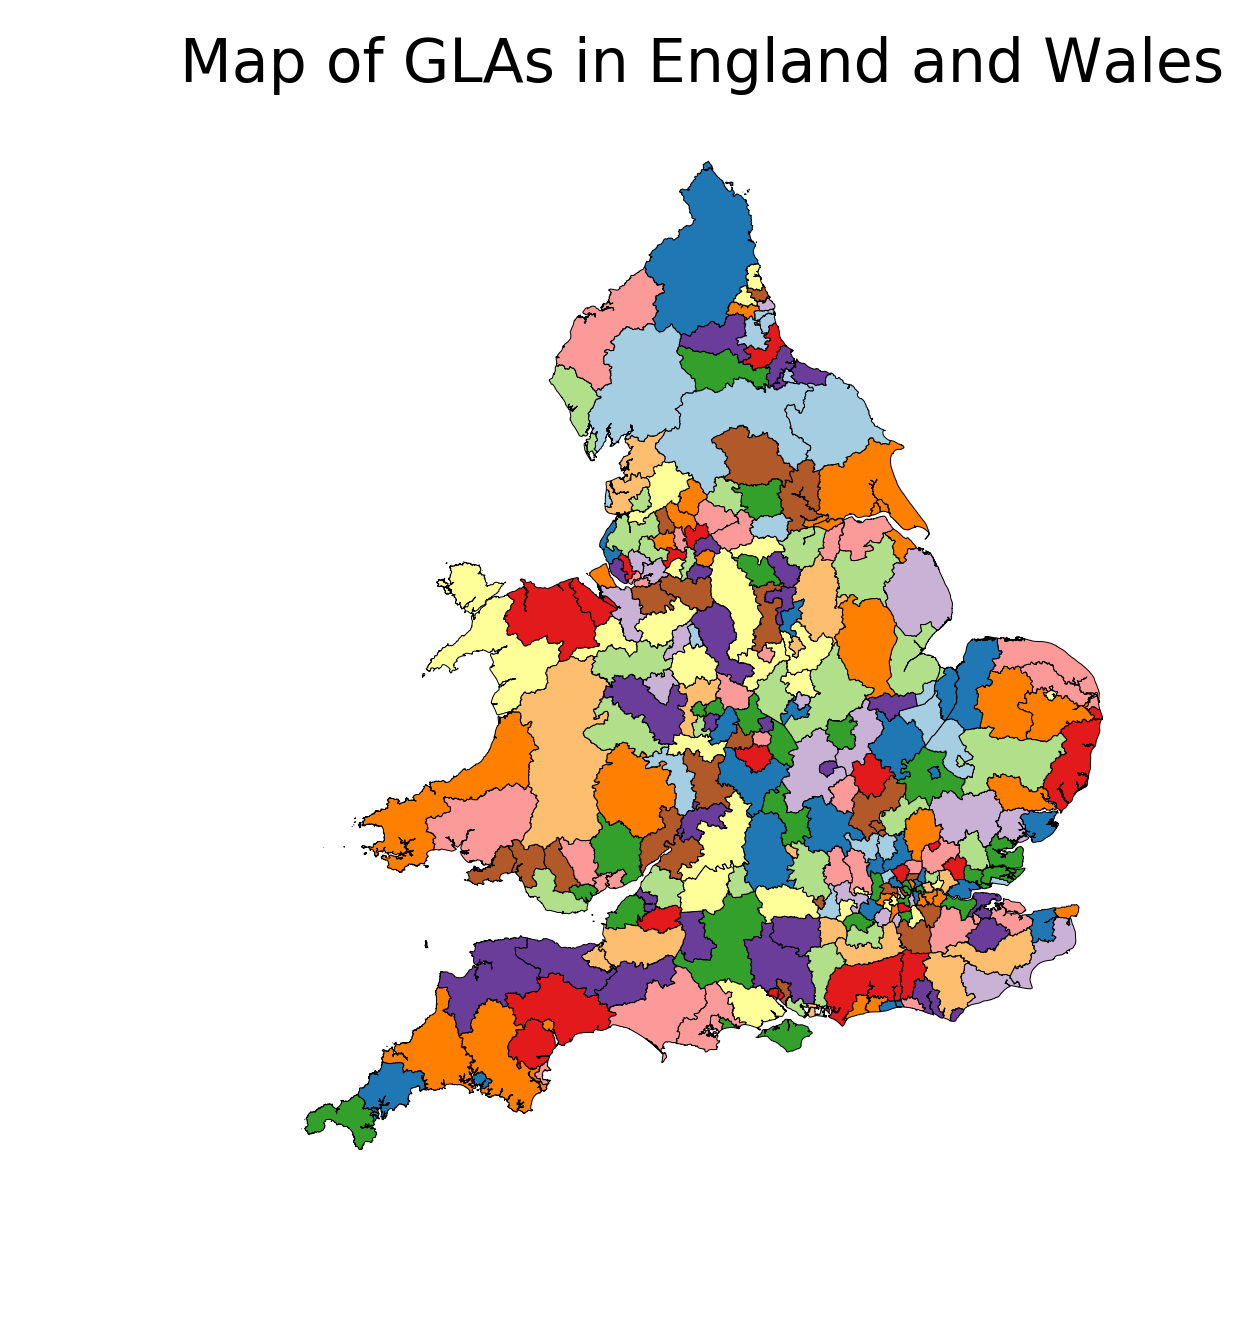

In [390]:
draw_map(ew_gla_map, title='Map of GLAs in England and Wales')

In [338]:
def la2gla(la_dict, gla_dict, verbose=False):
    la2gla_dict = dict()
    glas = list(gla_dict.keys())
    for key, val in la_dict.items():
        if key in glas: la2gla_dict[val] = gla_dict[key]
        else:
            found = False
            for gla in glas:
                if key in gla:
                    la2gla_dict[val] = gla_dict[gla]
                    found = True
                    break
            if not found and verbose: print('warning, no matching grouped-LA found for', key)
    return la2gla_dict

In [339]:
ew_la2gla_dict = la2gla(la_dict, ew_gla_dict)

In [391]:
def plot_attribute_by_la(df, la2gla_dict, map_object, attribute='health'):
    df_oi = df.groupby('lacode')[attribute].mean()
    colors = dict([(i, []) for i in map_object])
    for i in df_oi.index:
        if i in la2gla_dict: colors[la2gla_dict[i]].append(df_oi[i])
    for key in map_object:
        if colors[key]!=[]: colors[key] = sum(colors[key])/len(colors[key])
        else: del colors[key]
    draw_map(map_object, color=colors, cmap='Spectral', title=attribute+' by GLA in England and Wales', colorbar=True)
    return df_oi

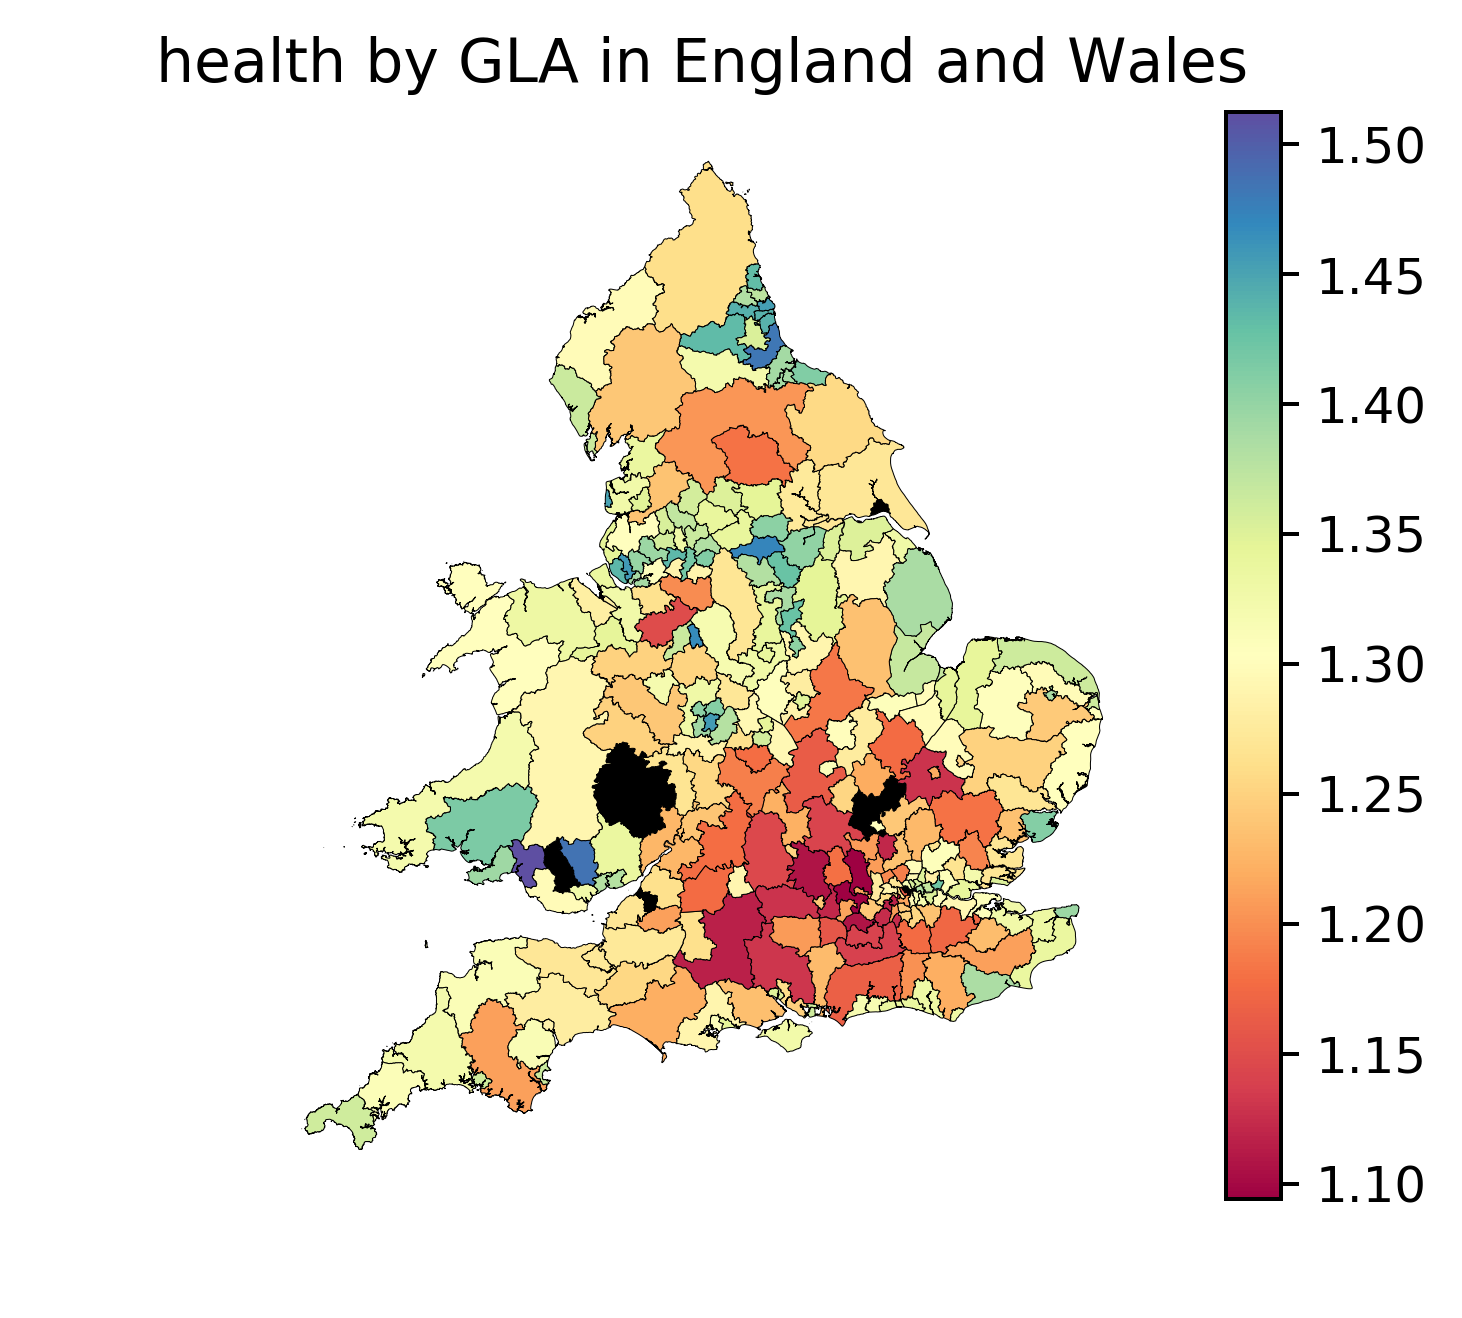

In [392]:
health_by_la_ew = plot_attribute_by_la(sam_data, ew_la2gla_dict, ew_gla_map, 'health')

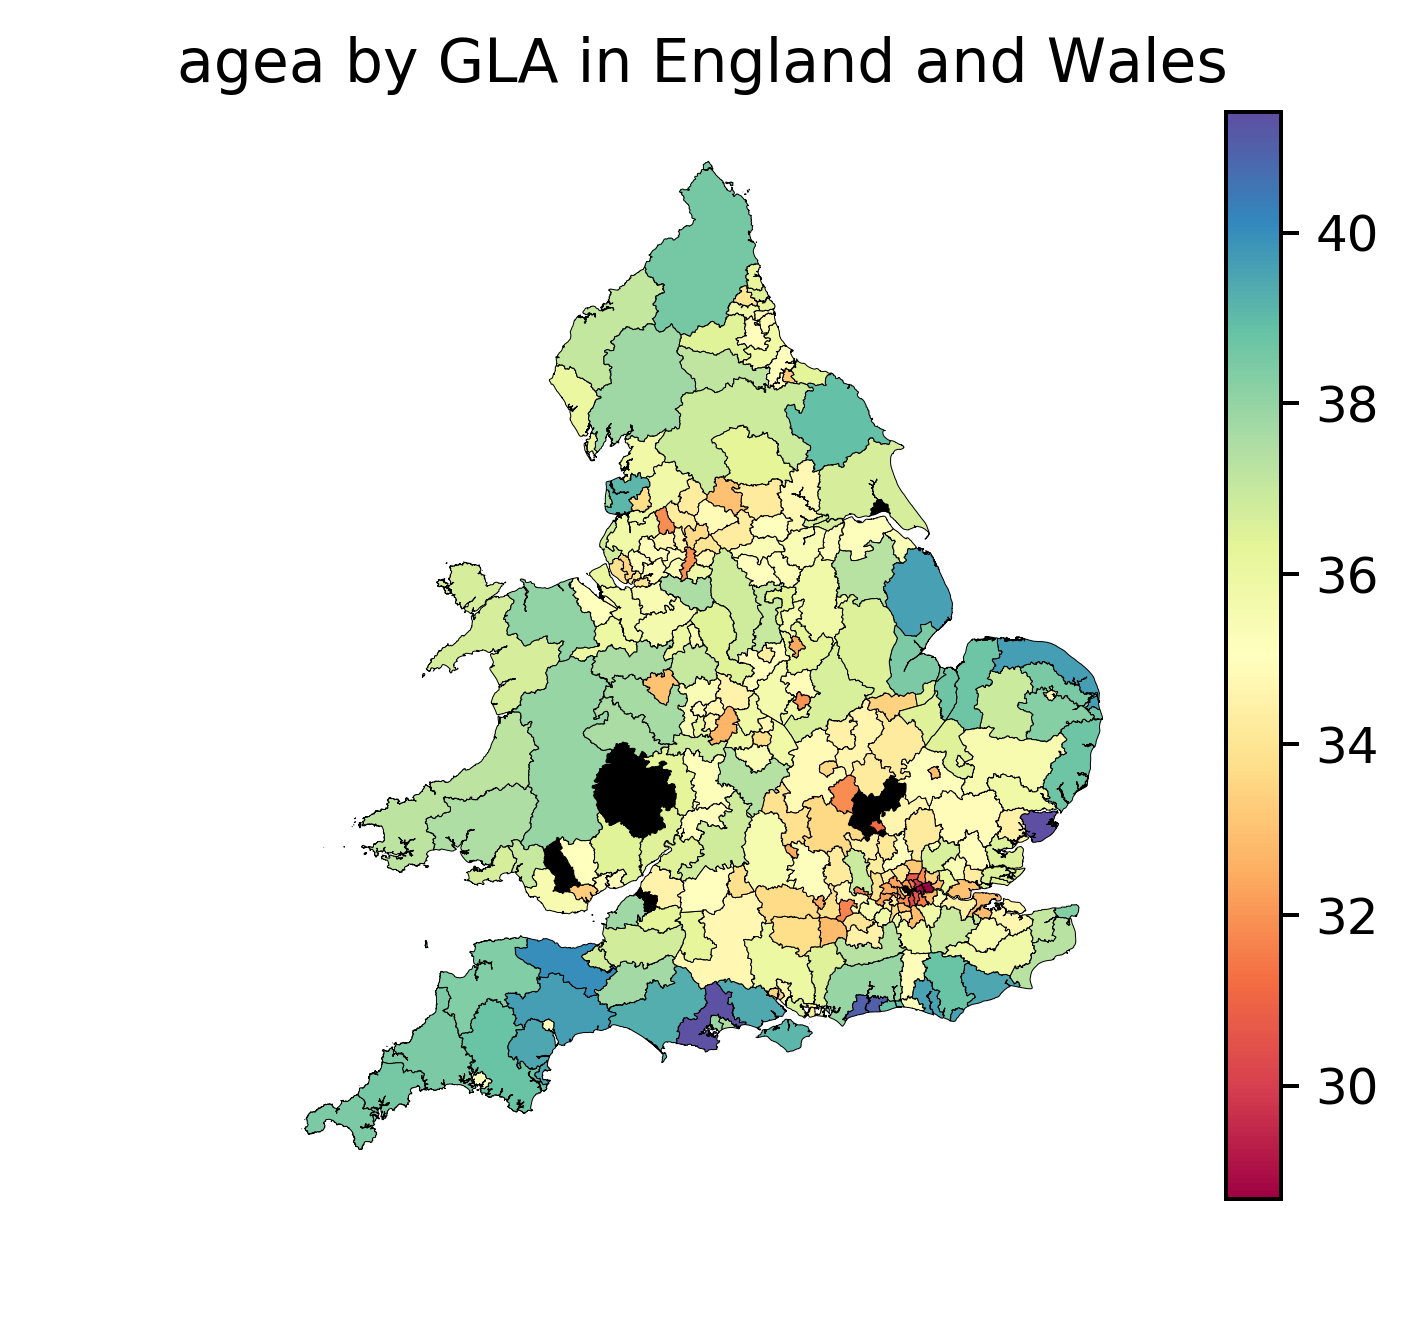

In [393]:
age_by_la_ew = plot_attribute_by_la(sam_data, ew_la2gla_dict, ew_gla_map, 'agea')

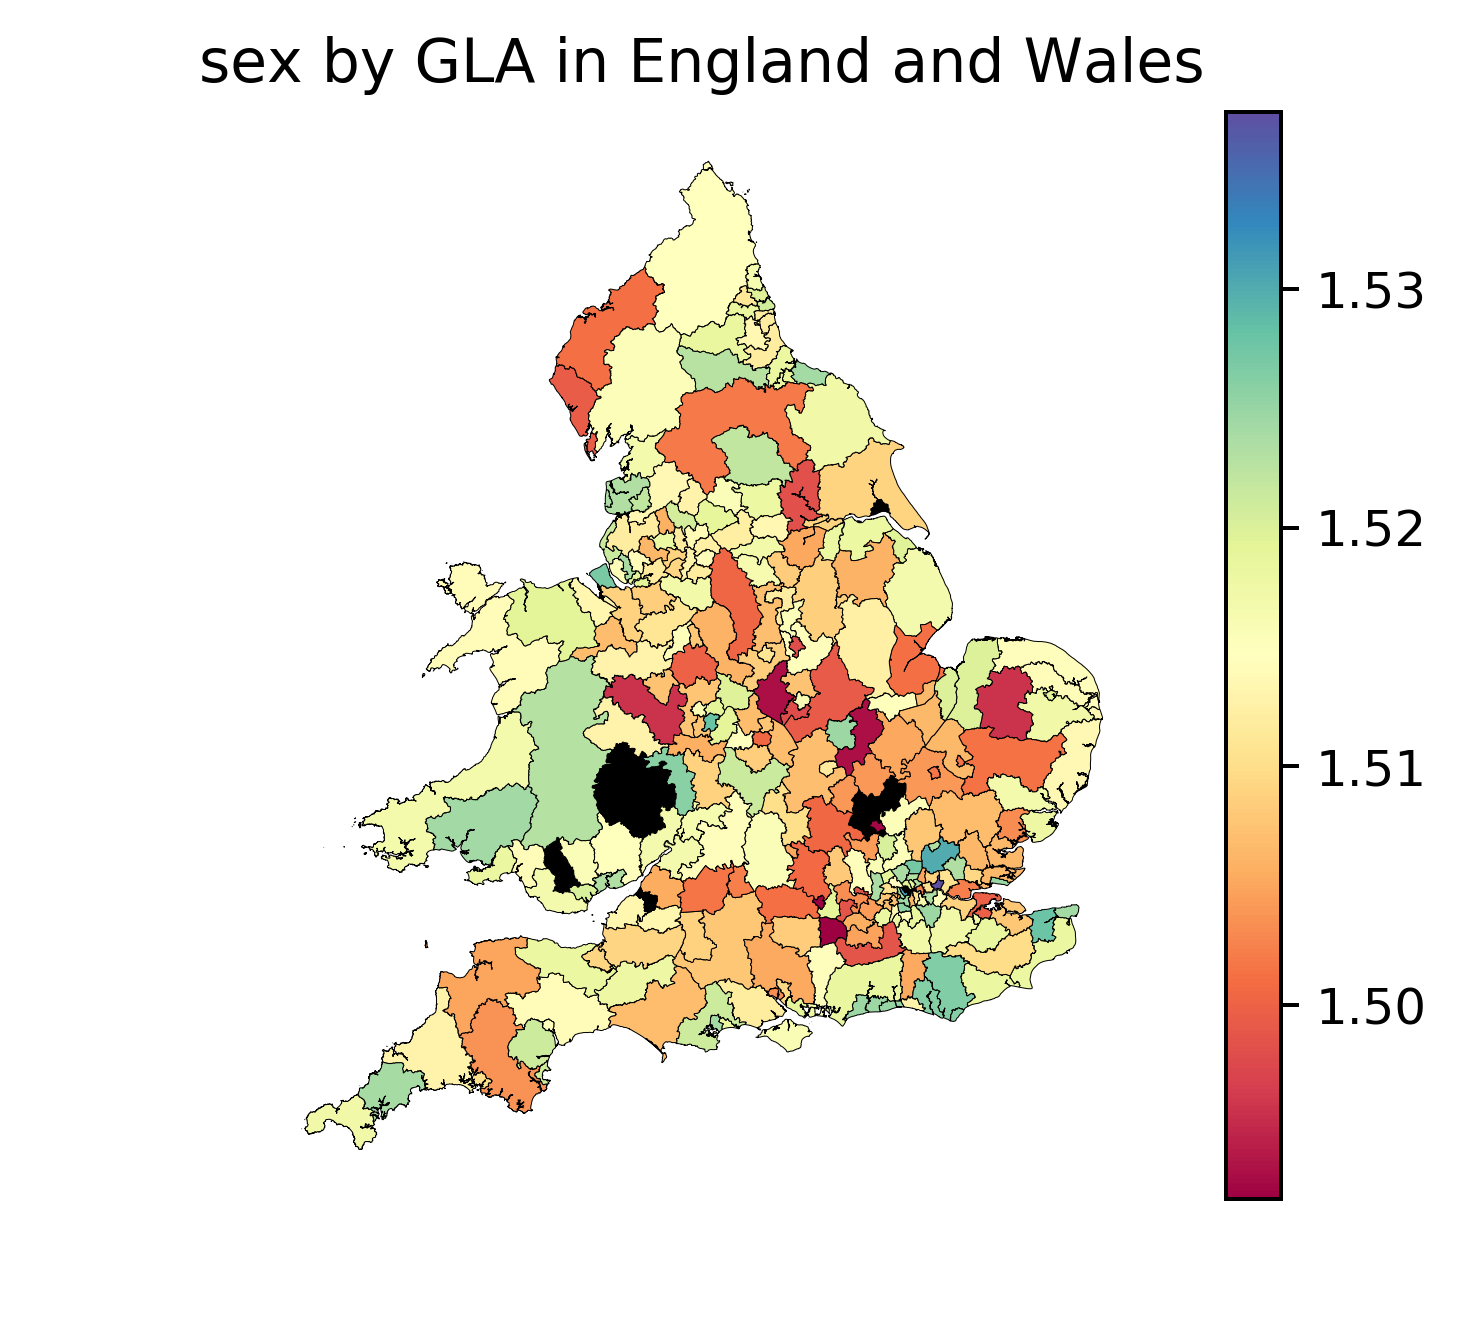

In [394]:
sex_by_la_ew = plot_attribute_by_la(sam_data, ew_la2gla_dict, ew_gla_map, 'sex')